# 7144COMP/CW2: Bird Multiple Object Detection Using Faster R-CNN ResNet101 Network 
## PART V: Deployment and Inference


In this notebook, I have frozen my trained model in the correct format for model inference. I deployed the saved model and made inferences on unseen data from the test subset and others downloaded from the Internet, using my trained model.

The results are discussed at the end of this notebook.

<img src="https://ayoubb.com/wp-content/uploads/2022/12/Screen-Recording-2022-12-24-at-9.38.43-PM.gif" />

*Figure: Deployment and inference on Roboflow Cloud* 
[>> Try this out](https://universe.roboflow.com/ayoubbensakhria/birdsod/model/2)

### Prerequisites
This notebook runs locally in the environment *tf-gpu*.
- Environment Setup (see Part 0)
- Preprocessing (see Part 1)
- Training (see Part 2)

## 1. Freeze our trained model's graph in a ```.pb``` format for model inferencing using ```exporter_main_v2.py``` script

- Graphs are data structures that contain a set of tf.Operation objects, which represent units of computation; and tf.Tensor objects, which represent the units of data that flow between operations. 

- Graphs are defined in a tf.Graph context. Since these graphs are data structures, they can be saved, run, and restored all without the original Python code.

Here we will save our OD inference graph files in  **fasterrcnn_inference_graph/saved_model** 

After freezing the TensorFlow graph for inference, TensorRT will optimize the TF sub-graphs. TensorRT then replaces each supported subgraph with a TensorRT optimized node, producing a frozen graph stored a **.pb file** that runs in TensorFlow for inference. The following flow chart illustrates the workflow (source: nVidia).
<img src="https://ayoubb.com/wp-content/uploads/2022/12/Flowchart-scaled.jpg" />

In [2]:
import os
import sys
import glob
import numpy as np
import tensorflow as tf

from PIL import Image
from six import BytesIO

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

# Check current conda environment
print(sys.executable)

/home/msc1/anaconda3/envs/tf_gpu/bin/python


In [4]:
current_dir = os.getcwd()
object_detection_dir = os.path.join(current_dir, 'models/research/object_detection')
# Labelmap
labelmap_path = os.path.join(current_dir, 'Birds', 'train', 'birds_label_map.pbtxt')
%cd $object_detection_dir

/home/msc1/Desktop/7144COMP/Models/faster_rcnn_resnet101/models/research/object_detection


In [5]:
# Output directory where out inference graph is saved
output_directory = 'fasterrcnn_inference_graph'

In [ ]:
# Freeze our model graph and save it in a .pb format  
!python $current_dir/models/research/object_detection/exporter_main_v2.py \
    --trained_checkpoint_dir $model_dir \
    --output_directory $output_directory \
    --pipeline_config_path $pipeline_config_path

#### saved_model.pb file (fasterrcnn_inference_graph/saved_model.pb)
.pb stands for Protocol Buffers, it is a language-neutral, platform-neutral extensible mechanism for serializing structured data (Our TF Graph). It is widely used in model deployment, such as fast inference tool TensorRT.

## 2. Perform inference on our frozen model using unseen test images

In [15]:
# Convert images to a numpy array
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path (this can be local or on colossus)

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Run inference for a numpay image
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  model_fn = model.signatures['serving_default']
  output_dict = model_fn(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

In [7]:
# Load label map data (for plotting)
category_index = label_map_util.create_category_index_from_labelmap(labelmap_path, use_display_name=True)

In [9]:
# Resets all states generated by Keras.
tf.keras.backend.clear_session()
# Load our model
model = tf.saved_model.load(f'/{current_dir}/{output_directory}/saved_model')

In [10]:
current_dir

'/home/msc1/Desktop/7144COMP/Models/faster_rcnn_resnet101'

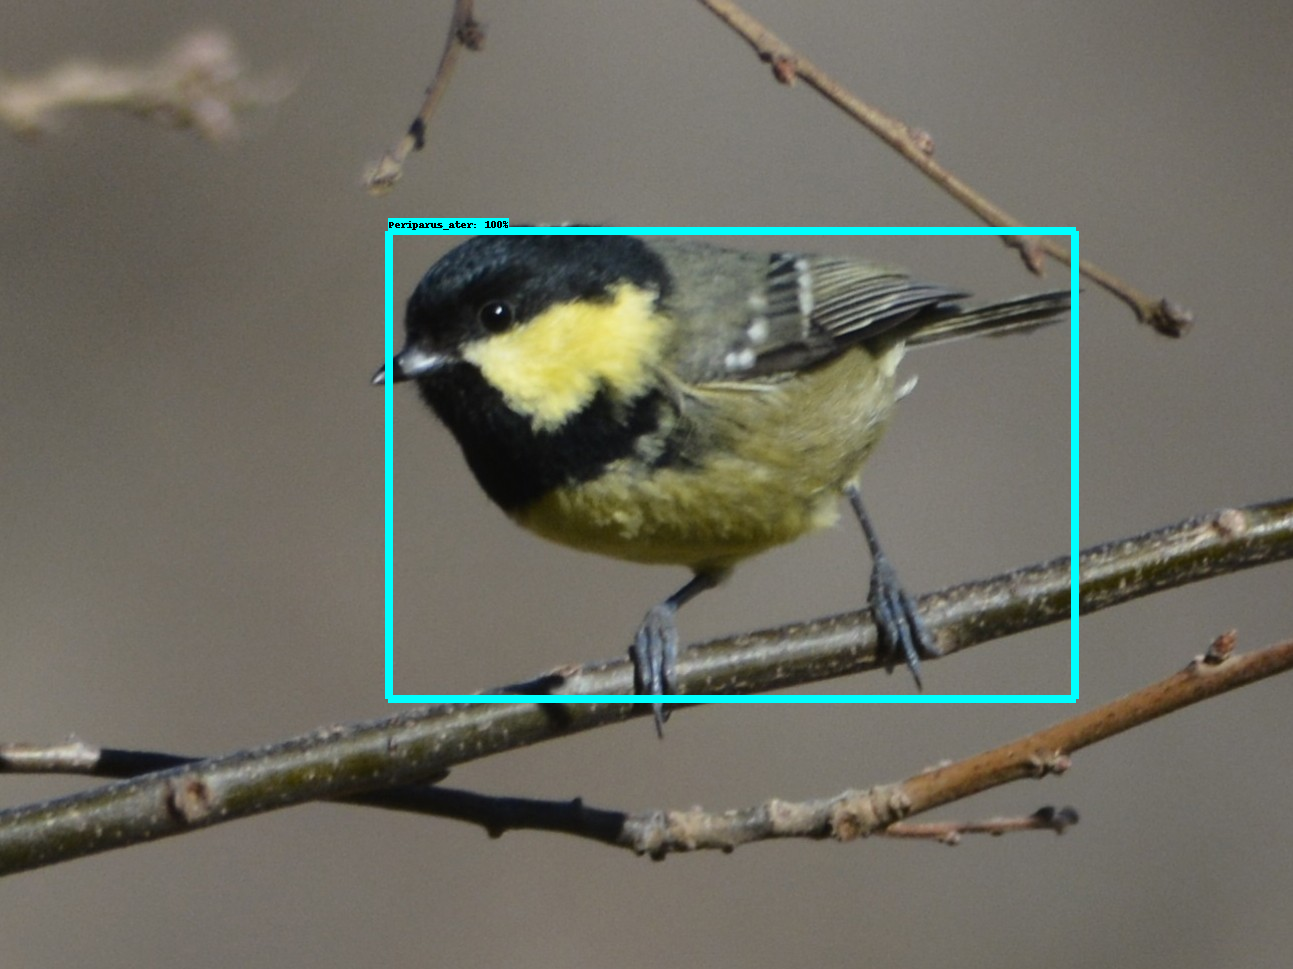

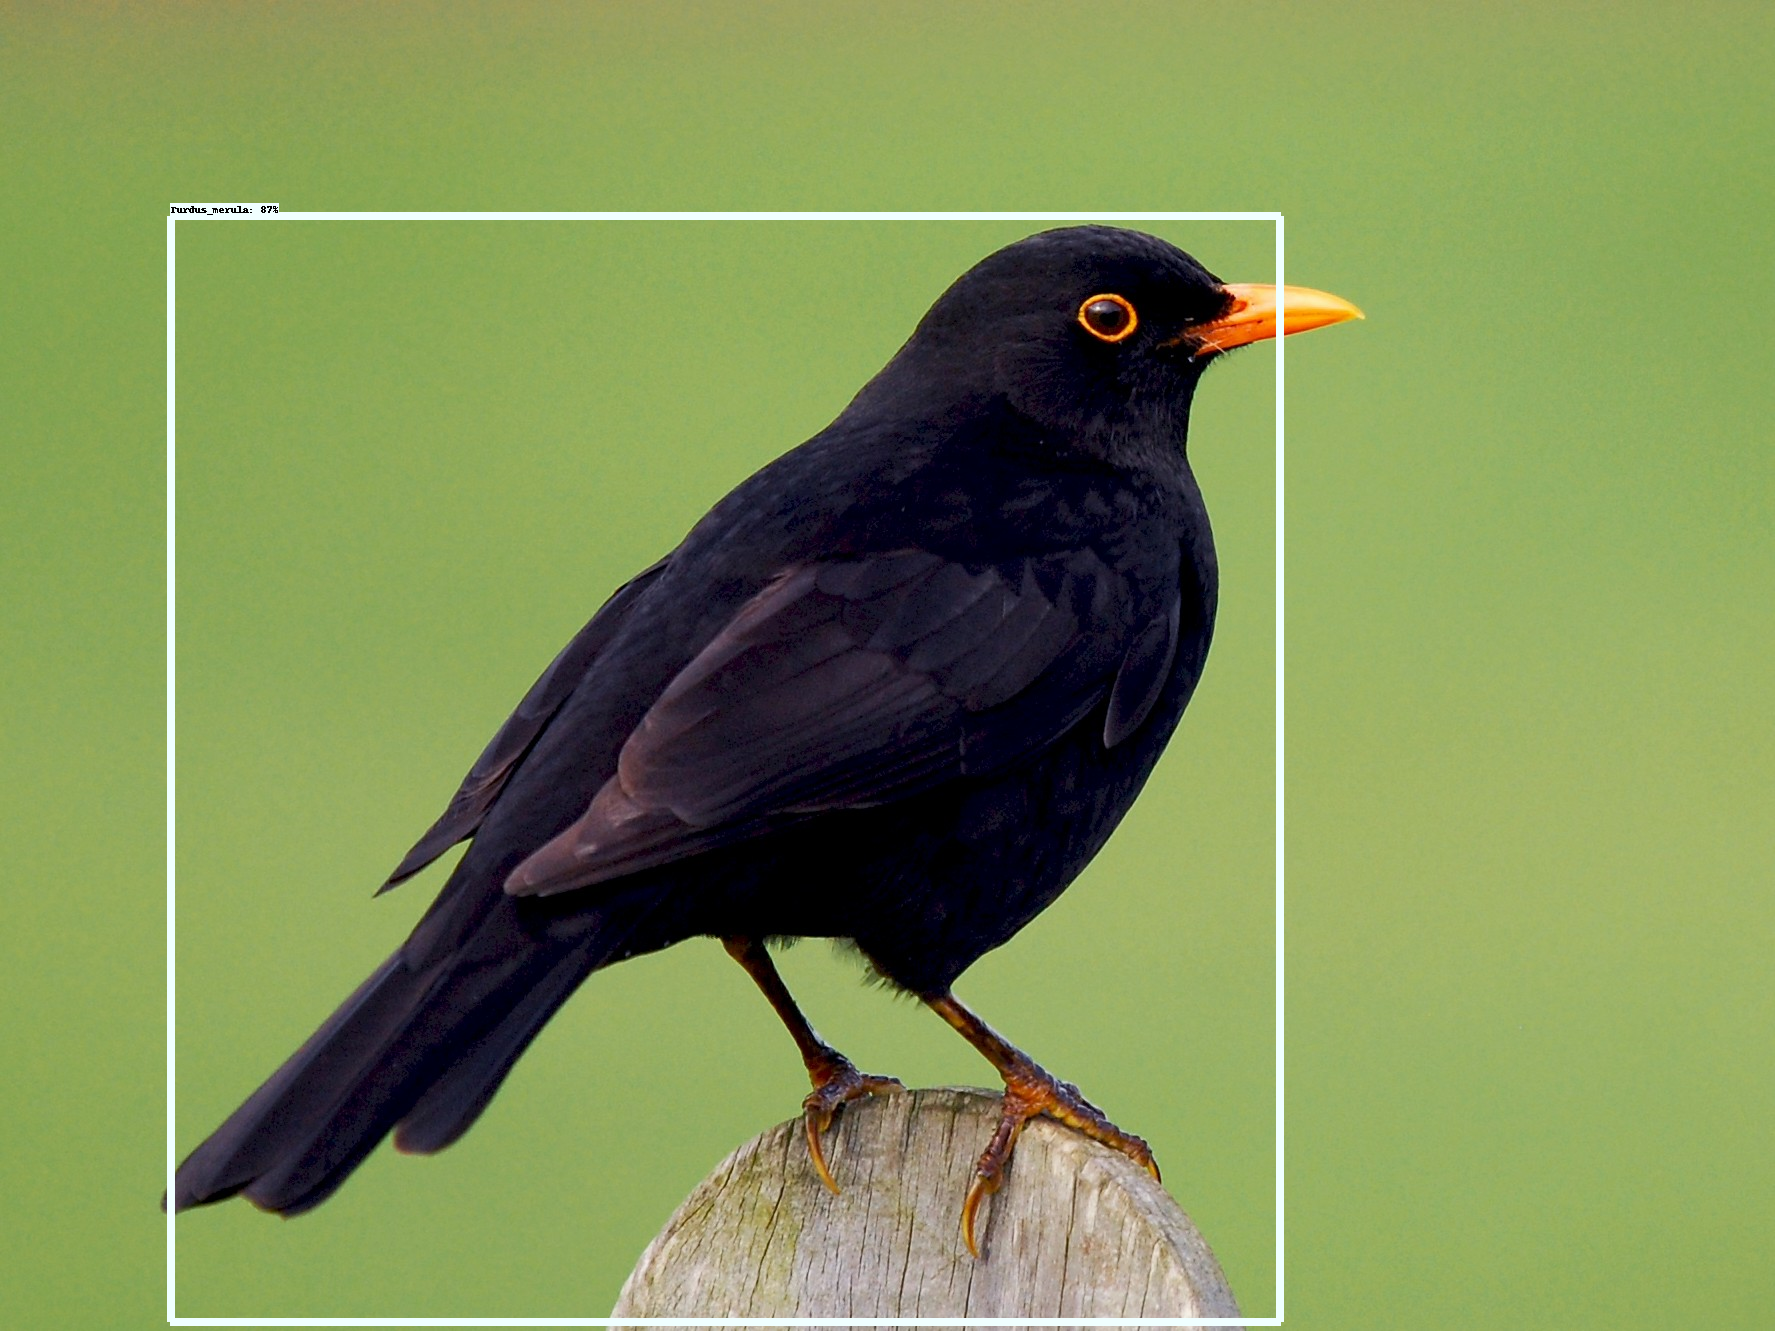

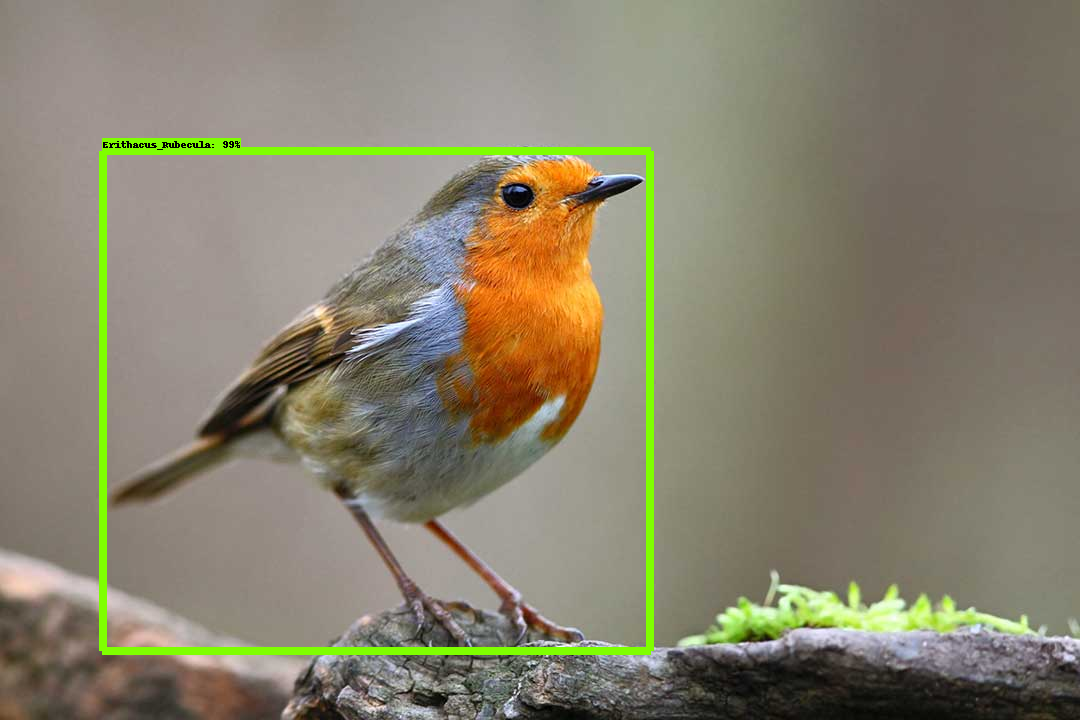

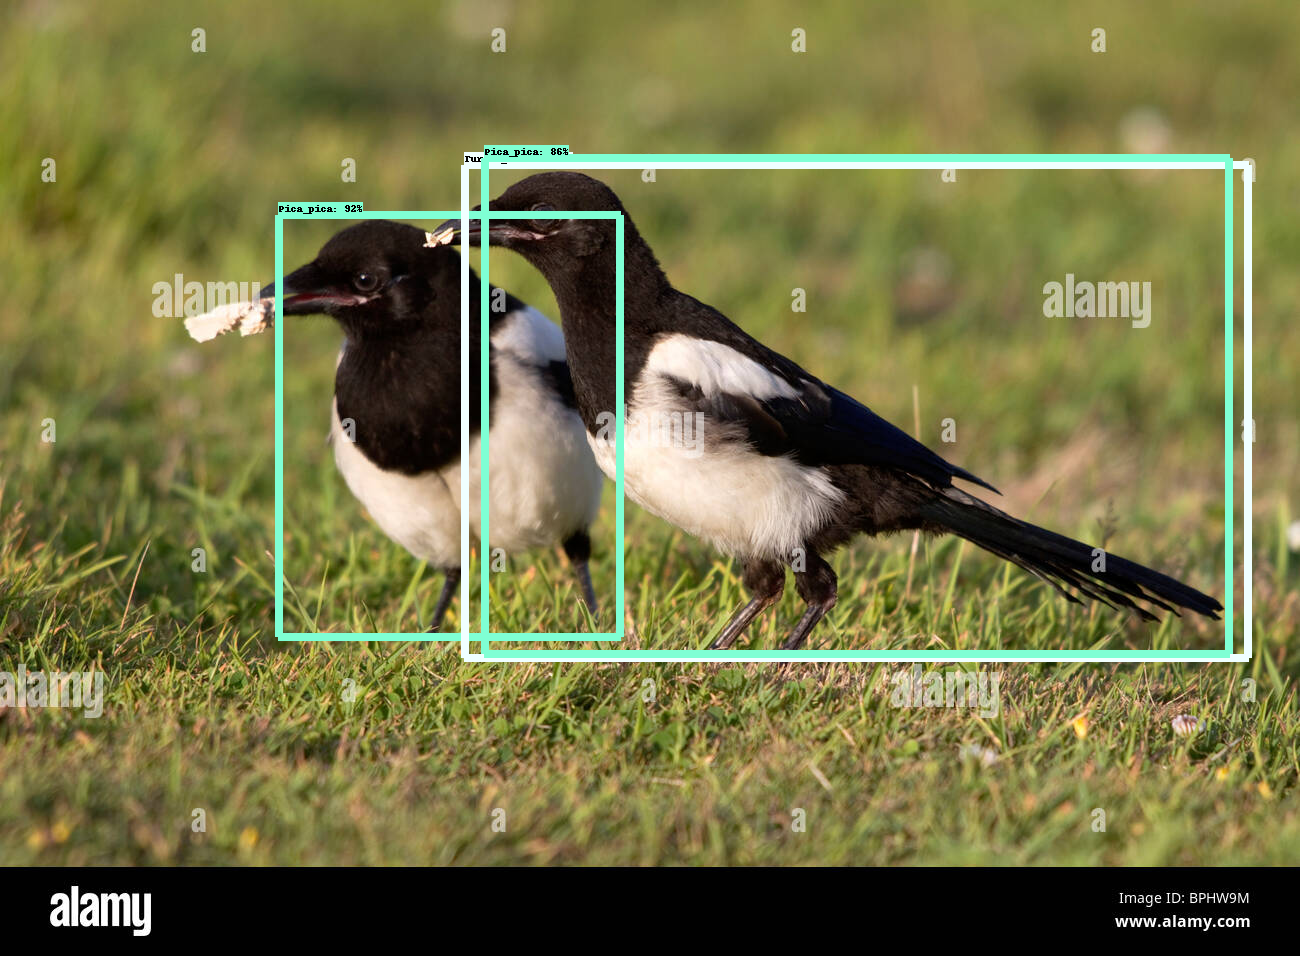

In [16]:
# Making inferences on images stored in Birds_test folder
# Birds_test folder contains unseen images downloaded from the Internet 
for image_path in glob.glob(os.path.join(current_dir,'Birds_test/*.jpg')):
  image_np = load_image_into_numpy_array(image_path)
  output_dict = run_inference_for_single_image(model, image_np)
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)
  # Display inferences with bounding boxes
  display(Image.fromarray(image_np))

## Discussion

- In this project, we used different approaches to improve the performance of a baseline ```faster_rcnn_resnet101_v1_640x640_coco17_tpu-8``` on a custom database (BBC AutmunWatch) for bird detection.

- The EDA results indicate that the BBC AutumnWatch is a high quality, balanced, but centrally biased dataset (annotations) with no corrupted images.

- the pre-processing and Hyperparameter tuning steps are crutial in sofar as they made the model more accurate after training.

- Although computer resources and the amount of training samples are limited, we can always reuse the saved model weights on another (usually larger) dataset to improve its performance thanks to transfer learning.

- Our mean average Precision scores at 0.5 and 0.75 levels of IoU were ```mAP@.5 = 0.8711``` and ```mAP@.75 = 0.6416``` respectively, our average Recall (sensitivity) score was ```AR = 0.6083``` which are acceptable compared to the model deployed on the could with an optimized training config. 

Comparison results of different extentions of the basic ```faster_rcnn_resnet101``` indicate the pre-trained model improved in mAP and AR using transfer learning on a custum database which makes it an interesting candidate for further investigations.

In summary, it is possible to improve the performance of the model. Further improvements can be made by further optimisation of the model hyper-parameters, use of stronger data augmentation, regularisation, meta-learning techniques, batch size, etc.
